## Self Supervised Learning 

## What is self supervised learing?
Self-supervised learning is a machine learing technique where the training data is labeled by the machine itself. Once we learn the representation of the data or features, we can use tranfer learing to fine tune the model for the task we want to solve.
 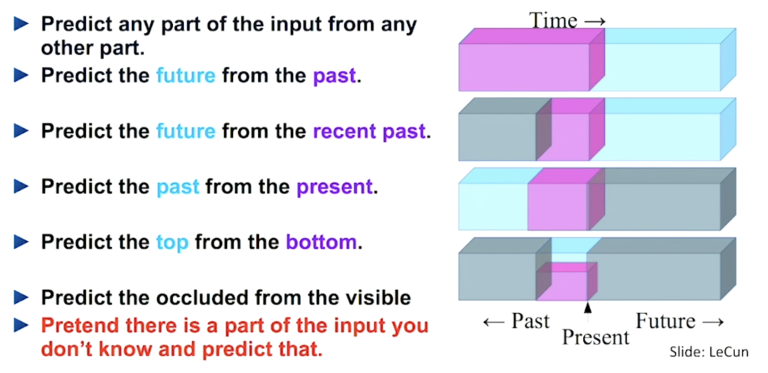

## Why self supervised learing?

* Self-supervised learning is a type of unsupervised learning. It is a way to learn useful features without human annotation.

* Data pre-processing is a time consuming and expensive process. Self-supervised learning can help us to reduce the cost of data preprocessing.



## How self supervised learing works?

write the steps here

* Step 1: Collect the data withour labels
* Step 2: Create a model
* Step 3: Train the model
* Step 4: Fine tune the model for the task we want to solve
* Step 5: Predict the model on test data
* Step 6: Evaluate the model


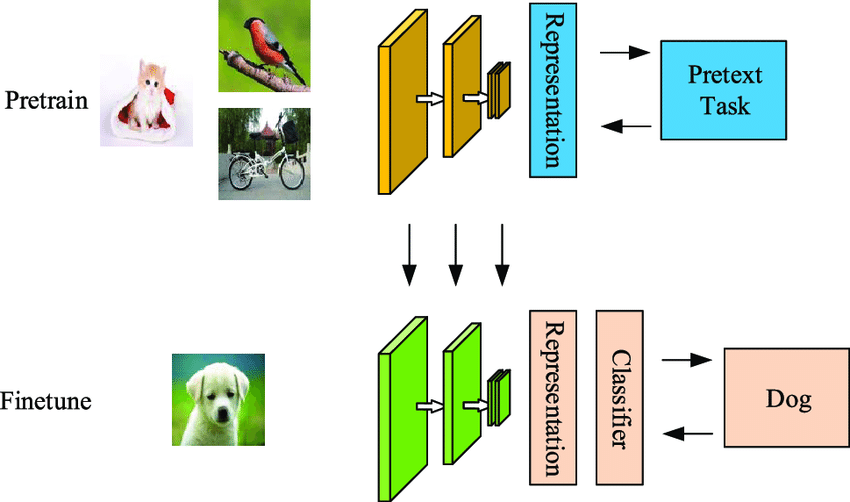

## Task 1: Image Classification using supervised learning 

### data: https://www.kaggle.com/c/dogs-vs-cats/data
### train set size: 10 dog + 10 cat
### test set size: 100 dog+cat


In [41]:
import os
import matplotlib.pyplot as plt
import glob
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

In [42]:

train_path = '/home/rishabh.mondal/label_image_FT'



### for class labels 

In [43]:
def class_label(train_path):
    class_labels = {'cat': 0, 'dog': 1}
    image_paths = []
    labels = []
    for class_name, class_label in class_labels.items():
        class_dir = os.path.join(train_path, class_name)
        class_image_paths = glob.glob(os.path.join(class_dir, '*.jpg'))
        image_paths.extend(class_image_paths)
        labels.extend([class_label] * len(class_image_paths))
    return image_paths, labels    
    print('Number of images found: ', len(image_paths))
    print('number of 0s: ', labels.count(0))
    print('number of 1s: ', labels.count(1))

### Function for display images 

In [44]:
import random

def display_images(image_paths, labels):
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    fig.subplots_adjust(hspace=0.5)
    data = list(zip(image_paths, labels))
    random.shuffle(data)
    image_paths, labels = zip(*data)
    for i in range(10): 
        ax = axes[i // 5, i % 5]
        img = cv2.imread(image_paths[i])
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
        ax.set_title('Label: ' + str(labels[i]))
        ax.axis('off')  


### Evaluate and plot 


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

def evaluate_and_plot(y_true, y_pred, class_labels):
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average='binary')
    plt.figure(figsize=(3, 2))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")

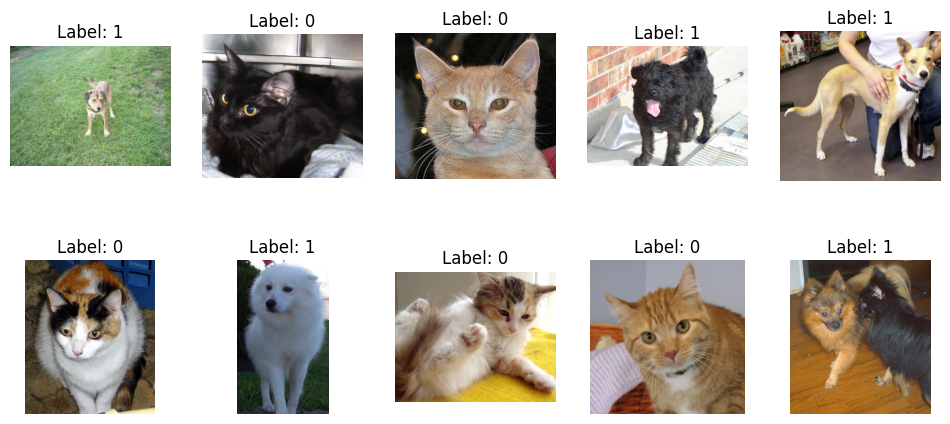

In [46]:

image_paths, labels=class_label(train_path)
display_images(image_paths, labels)


In [47]:
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

In [48]:
train_data = datasets.ImageFolder('/home/rishabh.mondal/label_image_FT', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [49]:
class VGGLike(nn.Module):
    def __init__(self,num_classes):
        super(VGGLike,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),  
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7,7))

        self.classifier = nn.Sequential(
            nn.Linear(512*7*7,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,num_classes),
        )
    def forward(self,x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x


In [50]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [51]:
# print model
model = VGGLike(num_classes=2)
model = model.to(device)
print(model)

VGGLike(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [52]:

# import torch.onnx

# dummy_input = torch.randn(1, 3, 224, 224)  

# # Export the model to ONNX
# onnx_file_path = "your_model.onnx"  
# torch.onnx.export(model, dummy_input, onnx_file_path, verbose=False)
# print("Model exported to ONNX successfully.")


In [53]:
#define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_list = []
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    loss_list.append(epoch_loss)
    
    print('Epoch: %d | Loss: %.4f' % (epoch + 1, epoch_loss))


Epoch: 1 | Loss: 0.6942
Epoch: 2 | Loss: 0.7289
Epoch: 3 | Loss: 0.7310
Epoch: 4 | Loss: 0.6995
Epoch: 5 | Loss: 0.6918
Epoch: 6 | Loss: 0.6963
Epoch: 7 | Loss: 0.6963
Epoch: 8 | Loss: 0.7130
Epoch: 9 | Loss: 0.6986
Epoch: 10 | Loss: 0.6904
Epoch: 11 | Loss: 0.6936
Epoch: 12 | Loss: 0.6993
Epoch: 13 | Loss: 0.6921
Epoch: 14 | Loss: 0.6931
Epoch: 15 | Loss: 0.6924
Epoch: 16 | Loss: 0.6923
Epoch: 17 | Loss: 0.6980
Epoch: 18 | Loss: 0.6906
Epoch: 19 | Loss: 0.6938
Epoch: 20 | Loss: 0.6816
Epoch: 21 | Loss: 0.8621
Epoch: 22 | Loss: 0.6844
Epoch: 23 | Loss: 0.6887
Epoch: 24 | Loss: 0.6974
Epoch: 25 | Loss: 0.6917
Epoch: 26 | Loss: 0.6934
Epoch: 27 | Loss: 0.7016
Epoch: 28 | Loss: 0.6918
Epoch: 29 | Loss: 0.6861
Epoch: 30 | Loss: 0.6913
Epoch: 31 | Loss: 0.6835
Epoch: 32 | Loss: 0.6950
Epoch: 33 | Loss: 0.7062
Epoch: 34 | Loss: 0.6730
Epoch: 35 | Loss: 0.6908
Epoch: 36 | Loss: 0.6851
Epoch: 37 | Loss: 0.6958
Epoch: 38 | Loss: 0.6978
Epoch: 39 | Loss: 0.6485
Epoch: 40 | Loss: 0.6972
Epoch: 41

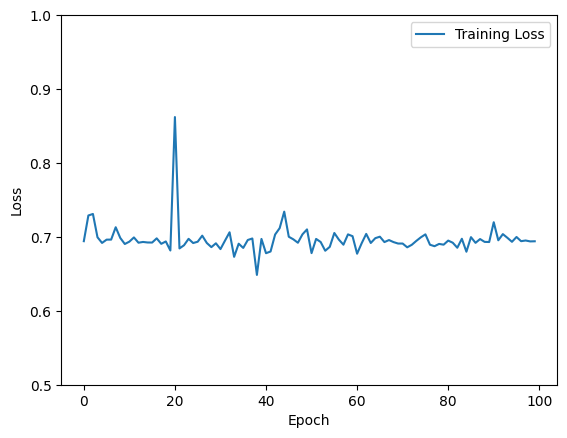

In [54]:
plt.plot(loss_list, label='Training Loss')
plt.ylim((.5,1.))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [55]:
# predict on test set
test_data = datasets.ImageFolder('/home/rishabh.mondal/test_images_CD', transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [56]:
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in test_loader:  
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  

        outputs = model(inputs)  
        _, predicted = outputs.max(1)

        total += labels.size(0)  
        correct += (predicted == labels).sum().item()  
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())
accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')



Validation Accuracy: 40.00%


Accuracy: 0.4
Precision: 0.4
Recall: 1.0
F1 Score: 0.5714285714285715


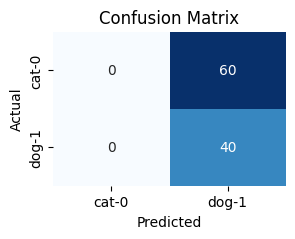

In [57]:
evaluate_and_plot(true_labels, predicted_labels, class_labels=["cat-0", "dog-1"])
